In [14]:
import seaborn as sns

sns.set_style("whitegrid")

import pathlib
import pickle as pkl
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

In [37]:
def time_to(per, arr):
    v = arr > per
    return np.argmax(v, axis=-1) - np.bitwise_not(np.any(v, axis=1)).astype(int)


def get_ttos_from_data(
    base,
    inv_norm=True,
    do_sum=True,
    step=0.01,
    isbin=False,
    weight=10,
    log=False,
    speed=False,
    output_size: Optional[int] = None,
    factor: Optional[int] = None,
):
    ttos, rg = compute_spread_ttos(
        base, step=step, output_size=output_size, factor=factor
    )

    if inv_norm:
        if do_sum:
            return ode_metric(
                ttos,
                do_sum=do_sum,
                isbin=isbin,
                wg=weight,
                log=log,
                speed=speed,
                step=step,
                output_size=output_size,
            )
        else:
            return ode_metric(
                ttos,
                do_sum=do_sum,
                isbin=isbin,
                wg=weight,
                log=log,
                speed=speed,
                step=step,
                output_size=output_size,
            )
    else:
        return ttos


def mean_tto(tto):
    res = []
    for k in tto:
        n = np.sum(k > -1)
        if n > 0:
            res.append([np.mean(k[k > -1]), n / len(k)])
        else:
            res.append([-1, 0])
    return res


def best_tto(tto):
    res = []
    for k in tto:
        n = np.sum(k > -1)
        if n > 0:
            res.append(np.min(k[k > -1]))
        else:
            res.append(-1)
    return res


def compute_spread_ttos(
    vec, step=0.01, output_size: Optional[int] = None, factor: Optional[float] = None
) -> np.ndarray:
    if output_size is not None:
        rg = np.arange(1 / output_size, 1, step)
    else:
        rg = np.arange(0, 1, step)
    res = np.array([time_to(p, vec) for p in rg]).astype(float)

    if factor is not None:
        res[res > 0] /= factor
    return res, rg


def ode_metric(
    ttos,
    wg=10,
    do_sum=True,
    isbin=False,
    log=False,
    speed=False,
    step=0.01,
    output_size: Optional[int] = None,
):
    r = (ttos + 1).astype(float)
    r[r == 0] = np.inf

    if not speed:
        weight = np.zeros(r.shape[0])
        fn = np.linspace if not log else np.logspace
        if isbin:
            weight[-r.shape[0] // 2 + 1 :] += fn(1, wg, r.shape[0] // 2)
        else:
            weight[-r.shape[0] :] += fn(1, wg, r.shape[0])
        weight = weight[:, None]
        weight /= weight.sum()
        res = weight * (1 / r)
    else:
        if output_size is not None:
            inv = 1 / output_size
            rg = (np.arange(inv, 1, step) - inv) / (1 - inv)
        else:

            rg = np.arange(0, 1, step)
            # rg = np.ones_like(np.arange(0, 1, step))

        weight = rg
        res = weight[:, None] * 1 / r

    # range_vec = np.arange(0, 1, step)
    range_vec = weight
    if do_sum:
        return (res / weight[:, None].sum()).sum(0)
    else:
        return res, range_vec
    
def numpy_ewma_vectorized(data, window):
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha

    scale = 1 / alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev ** (r + 1)
    pw0 = alpha * alpha_rev ** (n - 1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out

In [28]:
data_all.keys()

dict_keys(['LSTM', 'GRU', 'Transformer', 'RNN', 'Linear-init2'])

In [59]:
gpu = pathlib.Path("../experiment_gpu/")
data_all = {}
data = {}
opts = {}
for f in gpu.glob("*.pkl"):
    model = f.stem.split("_")[-1]
    if model not in ["rnn", "lstm", "gru", "dpout", "Linear-wd", "Linear", "Linear-init"]:
        if model not in data:
            data_all[model] = []
            data[model] = []
        dt, opts = pkl.load(open(f, "rb"))
        dt = np.array(dt)
        if model == "Linear-init2":
            dt[:, 1] = numpy_ewma_vectorized(dt[:, 1], 10)
            
        if dt[:, 0].max() > 150000:
            data_all[model].append(dt)

# Compute the minimal x-axis support for all the data and select only
# those points to make the ttos and aggregates possible
for k in data_all:
    base = set(data_all[k][0][:, 0])
    base.intersection_update(*[set(i[:, 0]) for i in data_all[k][1:]])
    base = np.array(sorted(base))
    for vec in data_all[k]:
        new_vec = np.array([i for i in vec if i[0] in base])
        data[k].append(new_vec)

for k in data:

    data[k] = data[k][:50]

In [60]:
print([(k, len(v)) for k, v in data.items()])

# for i in data["Transformer"]:
#    i[:, 1] /= 7

[('LSTM', 50), ('GRU', 50), ('Linear-init2', 50), ('Transformer', 50), ('RNN', 50)]


LSTM WADE 0.0227952797135458 Test accuracy 0.8894360000034331 Max test accuracy 0.9015296000030518
GRU WADE 0.027112907996731352 Test accuracy 0.8967688000000001 Max test accuracy 0.9043968
Linear WADE 0.037366461847068065 Test accuracy 0.8622777654968453 Max test accuracy 0.8622955735817017
Transformer WADE 0.0871555093206745 Test accuracy 0.8115608000000001 Max test accuracy 0.8719711999999998
RNN WADE 0.010281467535620764 Test accuracy 0.6359992 Max test accuracy 0.7047831999999998


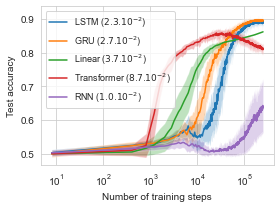

In [72]:
table = [
    "\\toprule",
    r"& \bfseries WADE $\times 10^{-2}$ (std.) & \bfseries Max test accuracy (std.) \\",
    "\\midrule",
]
fig, ax = plt.subplots(figsize=(4, 3))
for key, items in data.items():
    if key == "Linear-init2":
        key = "Linear"
    max_len = max(i.shape[0] for i in items)
    same_len = np.array([i for i in items if i.shape[0] == max_len])

    index = same_len[0, :, 0]
    results = same_len[:, :, 1]
    mean = results.mean(0)
    std = results.std(0)
    tto = get_ttos_from_data(results, do_sum=True, output_size=2)
    print(
        key,
        "WADE",
        tto.mean(),
        "Test accuracy",
        results[:, -1].mean(),
        "Max test accuracy",
        results.max(1).mean(),
    )
    table.append(
        f"{key} & {100 * tto.mean():.3f} ${{\scriptstyle \\pm{100 * tto.std():.3f}}}$ & {results.max(1).mean():.3f} ${{\scriptstyle \\pm{results.max(1).std():.3f} }}$ \\\\"
    )
    c = ax.fill_between(index, mean - std, mean + std, alpha=0.3)

    ax.plot(
        index,
        mean,
        color=c.get_facecolor()[0, :3],
        label=f"{key} (${100 * tto.mean():.1f}.10^{{-2}}$)",
    )
table.append("\\bottomrule")
plt.semilogx()
ax.legend(prop={"size": 9})
ax.set_xlabel("Number of training steps")
ax.set_ylabel("Test accuracy")
fig.tight_layout()
fig.savefig("/Users/hugo/Work/papers/neurips2022/figures/wade_supervised.pdf")

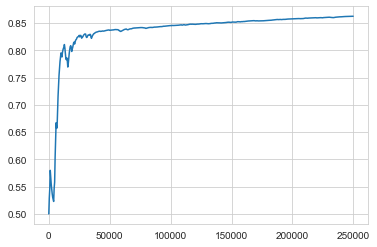

In [73]:
plt.plot(*data["Linear-init2"][0].T)

In [74]:
print("\n".join(table))

\toprule
& \bfseries WADE $\times 10^{-2}$ (std.) & \bfseries Max test accuracy (std.) \\
\midrule
LSTM & 2.280 ${\scriptstyle \pm0.303}$ & 0.902 ${\scriptstyle \pm0.002 }$ \\
GRU & 2.711 ${\scriptstyle \pm0.318}$ & 0.904 ${\scriptstyle \pm0.002 }$ \\
Linear & 3.737 ${\scriptstyle \pm0.745}$ & 0.862 ${\scriptstyle \pm0.000 }$ \\
Transformer & 8.716 ${\scriptstyle \pm0.720}$ & 0.872 ${\scriptstyle \pm0.003 }$ \\
RNN & 1.028 ${\scriptstyle \pm0.283}$ & 0.705 ${\scriptstyle \pm0.076 }$ \\
\bottomrule


In [68]:
results.max(1)

array([0.896  , 0.90136, 0.90256, 0.9022 , 0.9006 , 0.90288, 0.89684,
       0.90476, 0.90052, 0.89672, 0.90196, 0.90292, 0.90472, 0.9044 ,
       0.90328, 0.90276, 0.90232, 0.902  , 0.90228, 0.90356, 0.90156,
       0.89972, 0.90032, 0.8996 , 0.90244, 0.90012, 0.90328, 0.9018 ,
       0.90212, 0.90012, 0.90168, 0.90236, 0.90188, 0.89996, 0.90028,
       0.90184, 0.90412, 0.89956, 0.90448, 0.90204, 0.89996, 0.90156,
       0.90432, 0.90272, 0.8998 , 0.89988, 0.90252, 0.90216, 0.9026 ,
       0.90216, 0.89912, 0.90008, 0.90292, 0.90424, 0.90508, 0.89956,
       0.90588, 0.9036 , 0.9006 , 0.90124, 0.89952, 0.90244, 0.90012,
       0.9026 , 0.90044, 0.89952, 0.904  , 0.90212, 0.8948 , 0.90016,
       0.90136])